In [23]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    %matplotlib widget
    figsize=(9, 3)
else:
    figsize=(14, 4)

from util import util
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Load pre-trained models
fsm_early = keras.models.load_model('fsm_early')
fsm_late = keras.models.load_model('fsm_late')

# Generate dataset
nitems, nsamples = 10, 500
data = util.generate_market_dataset(nsamples, nitems, seed=2, noise=.02)
data_tr, data_ts = util.train_test_split(data, test_size=0.3, seed=42)
tr_in, tr_out = data_tr.index.values, data_tr.values
ts_in, ts_out = data_ts.index.values, data_ts.values

# Define the optimization problem
prb = util.generate_market_problem(nitems=nitems, rel_req=0.5, seed=42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Decision-Focused Learning

## The Main Challenge

**We are now ready to tackled decision-focused learning**

Let's start from the "holy grail" problem:

$$
\text{argmin}_{\theta} \left\{ \sum_{i=1}^m c(z^*(y_i), \hat{y}_i) \mid y = f(\hat{x}, \theta) \right\}
$$

**Unfortunately, the $\text{argmin}$ used to define $z^*(y_i)$ is _non-differentiable_**

* A small change in the prediction vector $y_i$
* ...May cause a large/discrete change in the optimal solution $z_i$

This is certainly the case for our example problem

> **How are we going to deal with this?**

## Towards a Solution

**A possible solution consists in using a _surrogate loss_**

For the $i$-th example:

* Since $z^*(\hat{y}_i)$ is the _true optimal solution_ for the true costs $\hat{y}_i$
* We expect that to _remain optimal_ for any good vector $y_i$ of predicted paramters

**In practice, we could train the model to minimize this _contrastive loss_:**

$$
c(z^*(\hat{y}_i), y_i) - c(z^*(y_i), y_i)
$$

$z^*(y_i)$ is the cost minimizer for the estimated parameters $y_i$

* I.e. our model _thinks_ that this is the correct solution for the $i$-th example
* ..But $z^*(\hat{y}_i)$ is the true optimum for the example

**The contrastive terms pushes the ML model towards correcting the mistake**

## Towards a Solution

**Let's consider again our contrastive loss:**

$$
c(z^*(\hat{y}_i), y_i) - c(z^*(y_i), y_i)
$$

We wish to backpropagata by differentiating over $y_i = f(\hat{x}_i, \theta)$

* The loss contains a constant, i.e. $z^*(\hat{y}_i)$
* ...A non-differentiable term, i.e. $z^*(y_i)$ that still depends on $y_i$
* ...And finally a naturally differentiable term, i.e. $c(\cdot, y_i)$



**This will be enough for us**

* We will _pretend that $z^*(y_i)$ is fixed_, even if it depends on $y_i$
* It can be proved that, under some assumptions, this yields a valid [subgradient](https://en.wikipedia.org/wiki/Subderivative)

## An Example on Our Market Problem

**Let's use our market problem, for the $i$-th example**

$$
\text{argmin}_z \{ y_i^T z \mid v^T z \geq r, z \in \{0, 1\}^n \}
$$

This satisfied the required assumption

* In particular, the cost expression (i.e. $y_i^T z$) is differentiable in $y_i$

**Therefore, we can get a valid subgradient:**

* First we compute the optimal solution $z_i = z^*(y_i)$ ("in the forward pass")
* Then we compute $\nabla_{y} (y^T z_i^*(\hat{y}_i) - y^T z_i) = z_i^*(\hat{y}_i) - z^*(y_i)$
* I.e. the difference between optima w.r.t. the true and the predicted costs

We can do this by relying on automatic differentiation

## Almost There...

**Let's recap our plan**

* When we evaluate our ML model, we need to solve the market problem
* ...So as to compute $z^*(y_i)$ for each example (in the mini-batch)
* Then we compute the loss:

$$
L_{C}(y, \hat{y}) = \sum_{i = 1}^m y_i^T (z^*(\hat{y}_i) - z^*(y_i))
$$

Finally we can use automatic differentiation (as usual) to get the subgradient

> **Except that with linear costs this plan has a fatal flow**

## There, Finally!

**The problem is that our loss admits a _trivial solution_**

$$
L_{C}(y, \hat{y}) = \sum_{i = 1}^m y_i^T (z^*(\hat{y}_i) - z^*(y_i))
$$

* All contrastive terms are _non-negative_ by definition
* ...And it's _easy to make them null_ by just predicting $y_i = 0$ for all examples

**A [possible fix](https://people.cs.kuleuven.be/~tias.guns/files/ijcai21_nce_solpool.pdf) consists in using this modified function**

$$
L_{\mathit{CR}}(y, \hat{y}) = \sum_{i = 1}^m y_i^T (z^*(\hat{y}_i) - z^*(y_i)) + \hat{y}_i^T (z^*(y_i) - z^*(\hat{y}_i))
$$

* This is another surrogate loss (ready for subgradient computation)

## There, Finally!

**Let's examine the modified loss**

$$
L_{\mathit{CR}}(y, \hat{y}) = \sum_{i = 1}^m \underbrace{y_i^T (z^*(\hat{y}_i) - z^*(y_i))}_{\text{contrastive}} + \underbrace{\hat{y}_i^T (z^*(y_i) - z^*(\hat{y}_i))}_{\text{regret}}
$$

The new term $\hat{y}_i^T (z^*(y_i) - z^*(\hat{y}_i))$ is the _regret_:

* I.e. it's the additional cost we pay (under the true parameter values $\hat{y}_i$
* ...For not having guessed correctly the true optimal solution

Both terms are guaranteed non-negative and therefore $L_{CR}(y, \hat{y}) \geq 0$

**We wish _both terms to be small_ (hence the loss is valid)**

## There, Finally!

**It is convenient to rewrite the loss as:**

$$
L_{CR}(y, \hat{y}) = \sum_{i = 1}^m (y_i - \hat{y}_i)^T (z^*(\hat{y}_i) - z^*(y_i))
$$

This clarifies that it can be minimized in two ways:

* Either by making the two _solutions_ as similar as possible, i.e. $z^*(\hat{y}_i) \simeq z^*(y_i)$
* ...Or by making the two _costs_ as similar as possible, i.e. $y_i \simeq \hat{y}_i$

**Importantly, $y = 0$ is _no longer a minimizer_**

**There are other viable surrogate losses**

* A famous one is the SPO+, from [the "Smart Predict, then Optimize" paper](https://arxiv.org/abs/1710.08005)
* The field has been recently surveyed by [Kotari et al.](https://proceedings.mlr.press/v162/mandi22a/mandi22a.pdf)

# A DFL Implementation

## A Decision Focused Learning Implementation

**An implementation of the method is available in the `util` module**

The code relies (again) on subclassing the `keras.Model` class

```python
class DFLModel(keras.Model):
    def __init__(self, prb, ..., **params):
        super(DFLModel, self).__init__(**params)
        self.prb = prb
        ...
```

At construction time, we need to _pass the optimization problem_ as an argument

```python
nnin = keras.Input(input_size)
nnout = nnin
for h in hidden:
    nnout = layers.Dense(h, activation='relu')(nnout)
nnout = layers.Dense(output_size, activation=output_activation)(nnout)
model = DFLModel(problem, inputs=nnin, outputs=nnout, ...)
```

## A Decision Focused Learning Implementation

**The `fit` function is overloaded**

* We compute all the optimal solutions w.r.t. the true costs, i.e. $z^*(\hat{y}_i)$
* Then we calling the parent `fit` function

```python
def fit(self, X, y, **kwargs):
    # Precompute all solutions for the true costs
    self.sol_store = []
    for c in y:
        sol, closed = self.prb.solve(c, tlim=self.tlim)
        self.sol_store.append(sol)
    self.sol_store = np.array(self.sol_store)
    # Call the normal fit method
    return super(DFLModel, self).fit(X, y, **kwargs)
```

## A Decision Focused Learning Implementation

**In the `train_step` method, we compute the surrogate loss**

```python
    def train_step(self, data):
        x, costs_true = data
        ...
        with tf.GradientTape() as tape:
            costs = self(x, training=True) # obtain predictions
            sols, tsols = [], []
            for c, tc in zip(costs.numpy(), costs_true.numpy()):
                sol, closed = prb.solve(c, ...) # Best w.r.t. predictions
                sols.append(sol)
                tsol = self._find_best(tc) # Best w.r.t. true costs
                tsols.append(tsol)
            sols, tsols = np.array(sols), np.array(tsols)
            cdiff = costs - costs_true # cost difference
            sdiff = tsols - sols # solution difference
            loss = tf.reduce_mean(tf.reduce_sum(cdiff * sdiff, axis=1))
        ...
```

## Early Training

**Let's train our decision-focused model for a few epochs**

In [12]:
dfm_early = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, hidden=[], name='dfm', output_activation='linear')
%time history = util.train_dfl_model(dfm_early, tr_in, tr_out, epochs=30, verbose=1, validation_split=0)

Epoch 1/30
11/11 [==============================] - 1s 58ms/step - loss: 1.0399
Epoch 2/30
11/11 [==============================] - 1s 63ms/step - loss: 0.9810
Epoch 3/30
11/11 [==============================] - 1s 80ms/step - loss: 0.9249
Epoch 4/30
11/11 [==============================] - 1s 92ms/step - loss: 0.8474
Epoch 5/30
11/11 [==============================] - 1s 101ms/step - loss: 0.7762
Epoch 6/30
11/11 [==============================] - 1s 117ms/step - loss: 0.7148
Epoch 7/30
11/11 [==============================] - 1s 124ms/step - loss: 0.6652
Epoch 8/30
11/11 [==============================] - 1s 126ms/step - loss: 0.6217
Epoch 9/30
11/11 [==============================] - 1s 130ms/step - loss: 0.5786
Epoch 10/30
11/11 [==============================] - 1s 128ms/step - loss: 0.5353
Epoch 11/30
11/11 [==============================] - 1s 130ms/step - loss: 0.4757
Epoch 12/30
11/11 [==============================] - 1s 113ms/step - loss: 0.4267
Epoch 13/30
11/11 [==========

## What We Loose

**It works, but there are some issues**

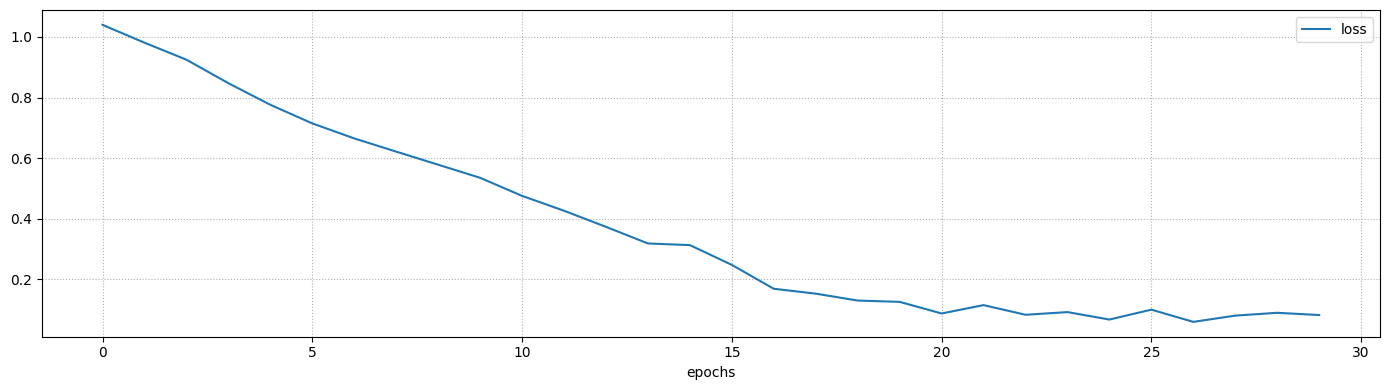

Final loss: 0.0826 (training)


In [13]:
util.plot_training_history(history, figsize=figsize)

* The loss curve is less smooth (since we are using a _sub_-gradient)
* Training takes longer (since we need to solve optimization problems)

## What We Loose

**We also loose _a lot_ in terms of accuracy**

These are the results for our previous "early" training model

In [14]:
r2, mae, rmse = util.get_ml_metrics(fsm_early, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(fsm_early, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

R2: -1.86, MAE: 0.32, RMSE: 0.43 (training)
R2: -1.92, MAE: 0.32, RMSE: 0.43 (test)


...And these are the results for the decision-focused model

In [15]:
r2, mae, rmse = util.get_ml_metrics(dfm_early, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(dfm_early, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

R2: -5.24, MAE: 0.6, RMSE: 0.65 (training)
R2: -5.37, MAE: 0.6, RMSE: 0.66 (test)


## What We Gain

**But in terms of regret, we are doing better!**

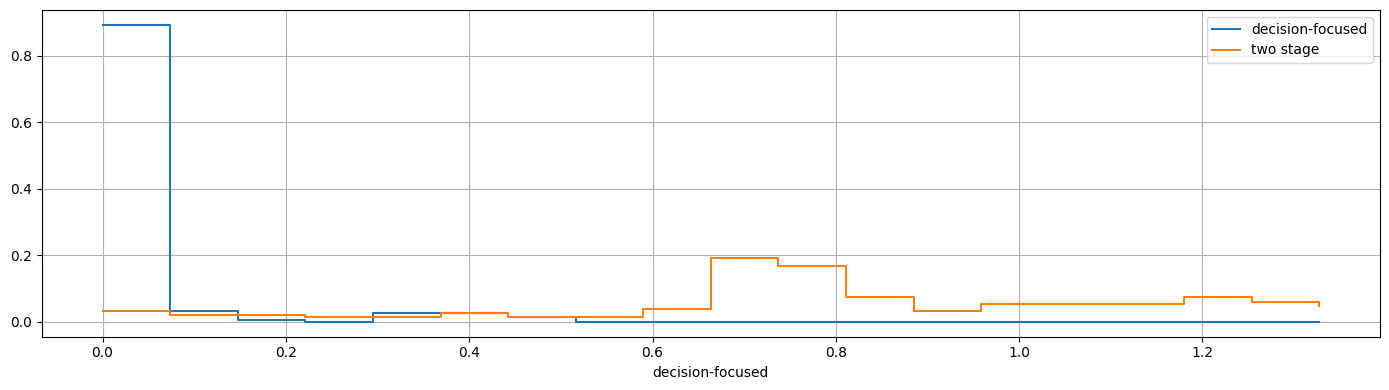

Mean: 0.034 (decision-focused), 0.825 (two stage)


In [16]:
r_ts_fsm_early = util.compute_regret(prb, fsm_early, ts_in, ts_out)
r_ts_dfm_early = util.compute_regret(prb, dfm_early, ts_in, ts_out)
util.plot_histogram(r_ts_dfm_early, figsize=figsize, label='decision-focused', data2=r_ts_fsm_early, label2='two stage', print_mean=True)

## Speeding Up the Process

**Training speed is a major bottleneck for decision-focused learning**

We will address that by [keeping a solution cache](https://people.cs.kuleuven.be/~tias.guns/files/ijcai21_nce_solpool.pdf)

* We store all computed solutions in a set $S$
* Then we compute $z^*(y_i)$ via simple enumeration:

$$
z^*(y_i) = \text{argmin}_{z \in S} c(z, y_i)
$$

**Occasionaly, we may compute a new solution and update the cache**

E.g. we can trigger this with a low probability per sample

**An alternative consists in [using a problem relaxation](https://arxiv.org/pdf/2010.13943)**

E.g. A Linear Programs instead of a Mixed Integer Linear Program

## Implementing Solution Caching

**A solution caching mechanism is implemented in our code**

The computation of $z^*(y_i)$ is triggered with a _controllable probability_

```python
def train_step(self, data):
    ...
    with tf.GradientTape() as tape:
        ...
        for c, tc in zip(costs.numpy(), costs_true.numpy()):
            if np.random.rand() < self.recompute_chance: # guard
                sol, closed = prb.solve(c, tlim=self.tlim) # recompute
                if self.recompute_chance < 1: # update cache
                    if not (self.sol_store == sol).all(axis=1).any():
                        self.sol_store = np.vstack((self.sol_store, sol))
            else:
                sol = self._find_best(c) # look up in the cache
            ...
        ...
```

## Training With Solution Caching

**Let's train the model with a solution cache and 5% recomputation chance**

CPU times: user 13.4 s, sys: 668 ms, total: 14.1 s
Wall time: 13.7 s


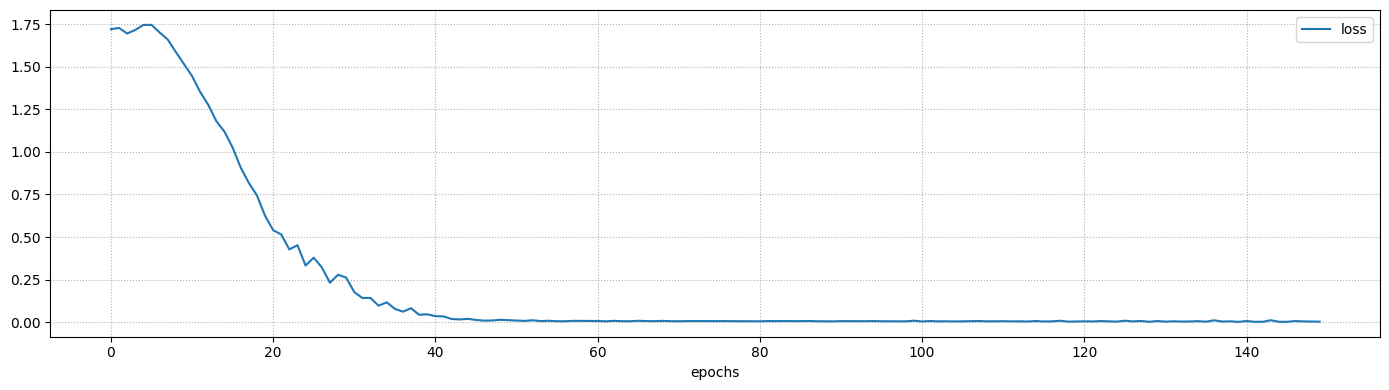

Final loss: 0.0023 (training)


In [18]:
dfm_late = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, recompute_chance=0.05, hidden=[], name='dfm_cache', output_activation='linear')
%time history = util.train_dfl_model(dfm_late, tr_in, tr_out, epochs=150, verbose=0, validation_split=0)
util.plot_training_history(history, figsize=figsize)

## Accuracy Comparison

**Since we manage to train the model to (approximate) convergence**

...It makes sense to compare with the "late" linear regression approach

In [20]:
r2, mae, rmse = util.get_ml_metrics(fsm_late, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(fsm_late, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

R2: 0.79, MAE: 0.097, RMSE: 0.12 (training)
R2: 0.78, MAE: 0.1, RMSE: 0.12 (test)


In terms of accuracy we are doing still quite poorly

In [21]:
r2, mae, rmse = util.get_ml_metrics(dfm_late, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(dfm_late, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

R2: -7.00, MAE: 0.66, RMSE: 0.74 (training)
R2: -7.27, MAE: 0.66, RMSE: 0.74 (test)


## Regret Comparison

**Both approaches work well, but we beat LR by a factor of at least 2**

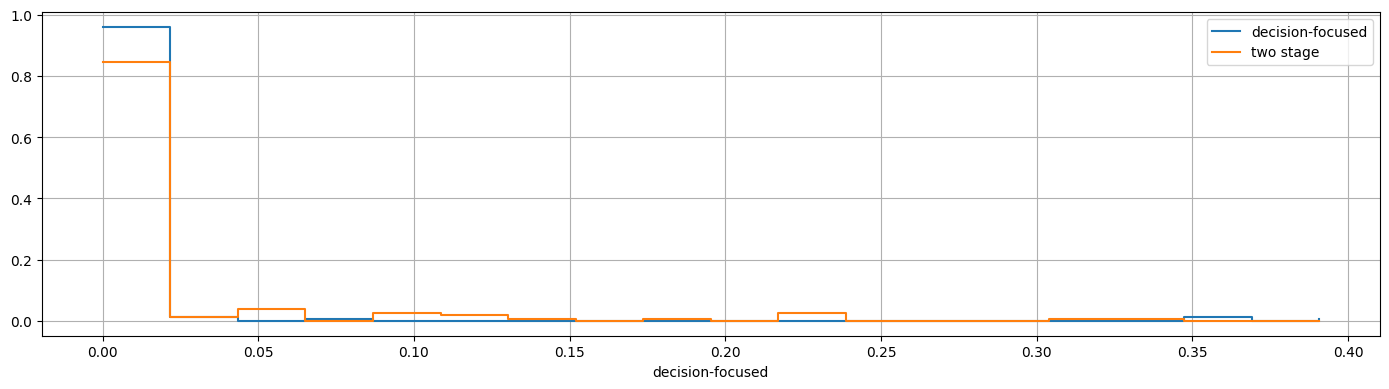

Mean: 0.009 (decision-focused), 0.020 (two stage)


In [22]:
r_ts_fsm_late = util.compute_regret(prb, fsm_late, ts_in, ts_out)
r_ts_dfm_late = util.compute_regret(prb, dfm_late, ts_in, ts_out)
util.plot_histogram(r_ts_dfm_late, figsize=figsize, label='decision-focused', data2=r_ts_fsm_late, label2='two stage', print_mean=True)